# FAST-based feature filtering demo

This notebook demonstrates internal FAST-based feature filtering for factual explanations.

The core idea:
- Run an internal FAST pass on the same batch to obtain per-instance feature weights.
- Aggregate those weights and keep only the top-k most important features for the batch.
- Run the full factual explanation on this reduced feature set, reducing compute cost.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from calibrated_explanations import WrapCalibratedExplainer, __version__
from calibrated_explanations.api.config import ExplainerBuilder

print(f"Using calibrated_explanations version: {__version__}")

Using calibrated_explanations version: v0.10.2


In [3]:
# Generate a simple classification dataset with many features
X, y = make_classification(
    n_samples=2000,
    n_features=2000,
    n_informative=5,
    n_redundant=5,
    random_state=42,
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=50, random_state=42)
X_train_proper, X_cal, y_train_proper, y_cal = train_test_split(
    X_train, y_train, test_size=200, random_state=42
)

learner = RandomForestClassifier(n_estimators=50, random_state=42)
learner.fit(X_train_proper, y_train_proper)

RandomForestClassifier(n_estimators=50, random_state=42)

In [4]:
# Build an ExplainerConfig with internal feature filtering enabled
builder = ExplainerBuilder(learner)
config = (
    builder.task("classification")
    .perf_parallel(False)  # Disabled parallelism
    .perf_feature_filter(True, per_instance_top_k=5)
    .build_config()
)

# Construct the wrapper from the config
wrapper = WrapCalibratedExplainer.from_config(config)

# Calibrate the explainer (perf cache/parallel + feature filter are wired internally)
wrapper.calibrate(X_cal, y_cal)
explainer = wrapper.explainer
explainer

CalibratedExplainer(mode=classification, learner=RandomForestClassifier(n_estimators=50, random_state=42))

In [5]:
# Run factual explanations with internal FAST-based feature filtering enabled
explanations = wrapper.explain_factual(X_test)

In [6]:
explanations[:5].to_narrative()

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\calibrated_explanations\explanations\explanations.py:1270: UserWarning: Narrative template fallback: default template used because provided relative path was missing
  return plugin.plot(


,instance_index,factual_explanation_beginner,factual_explanation_advanced,expertise_level,problem_type
0,0,Prediction: 1\nCalibrated Probability: 0.545 [...,Prediction: 1\nCalibrated Probability: 0.545\n...,"(beginner, advanced)",binary_classification
1,1,Prediction: 1\nCalibrated Probability: 0.714 [...,Prediction: 1\nCalibrated Probability: 0.714\n...,"(beginner, advanced)",binary_classification
2,2,⚠️ Use caution: uncertainty is high.\n\nPredic...,⚠️ Use caution: calibrated probability interva...,"(beginner, advanced)",binary_classification
3,3,Prediction: 1\nCalibrated Probability: 0.300 [...,Prediction: 1\nCalibrated Probability: 0.300\n...,"(beginner, advanced)",binary_classification
4,4,Prediction: 1\nCalibrated Probability: 0.545 [...,Prediction: 1\nCalibrated Probability: 0.545\n...,"(beginner, advanced)",binary_classification


Prediction [ Low ,  High]
0.545 [0.526, 0.568]
Value : Feature                                  Weight [ Low  ,  High ]
-0.39 : 355 > -1.22                              -0.080 [-0.122, -0.055]
-1.21 : 7 <= 5.02                                -0.057 [-0.092, -0.035]
-0.23 : 459 <= 0.45                              -0.012 [-0.034,  0.005]



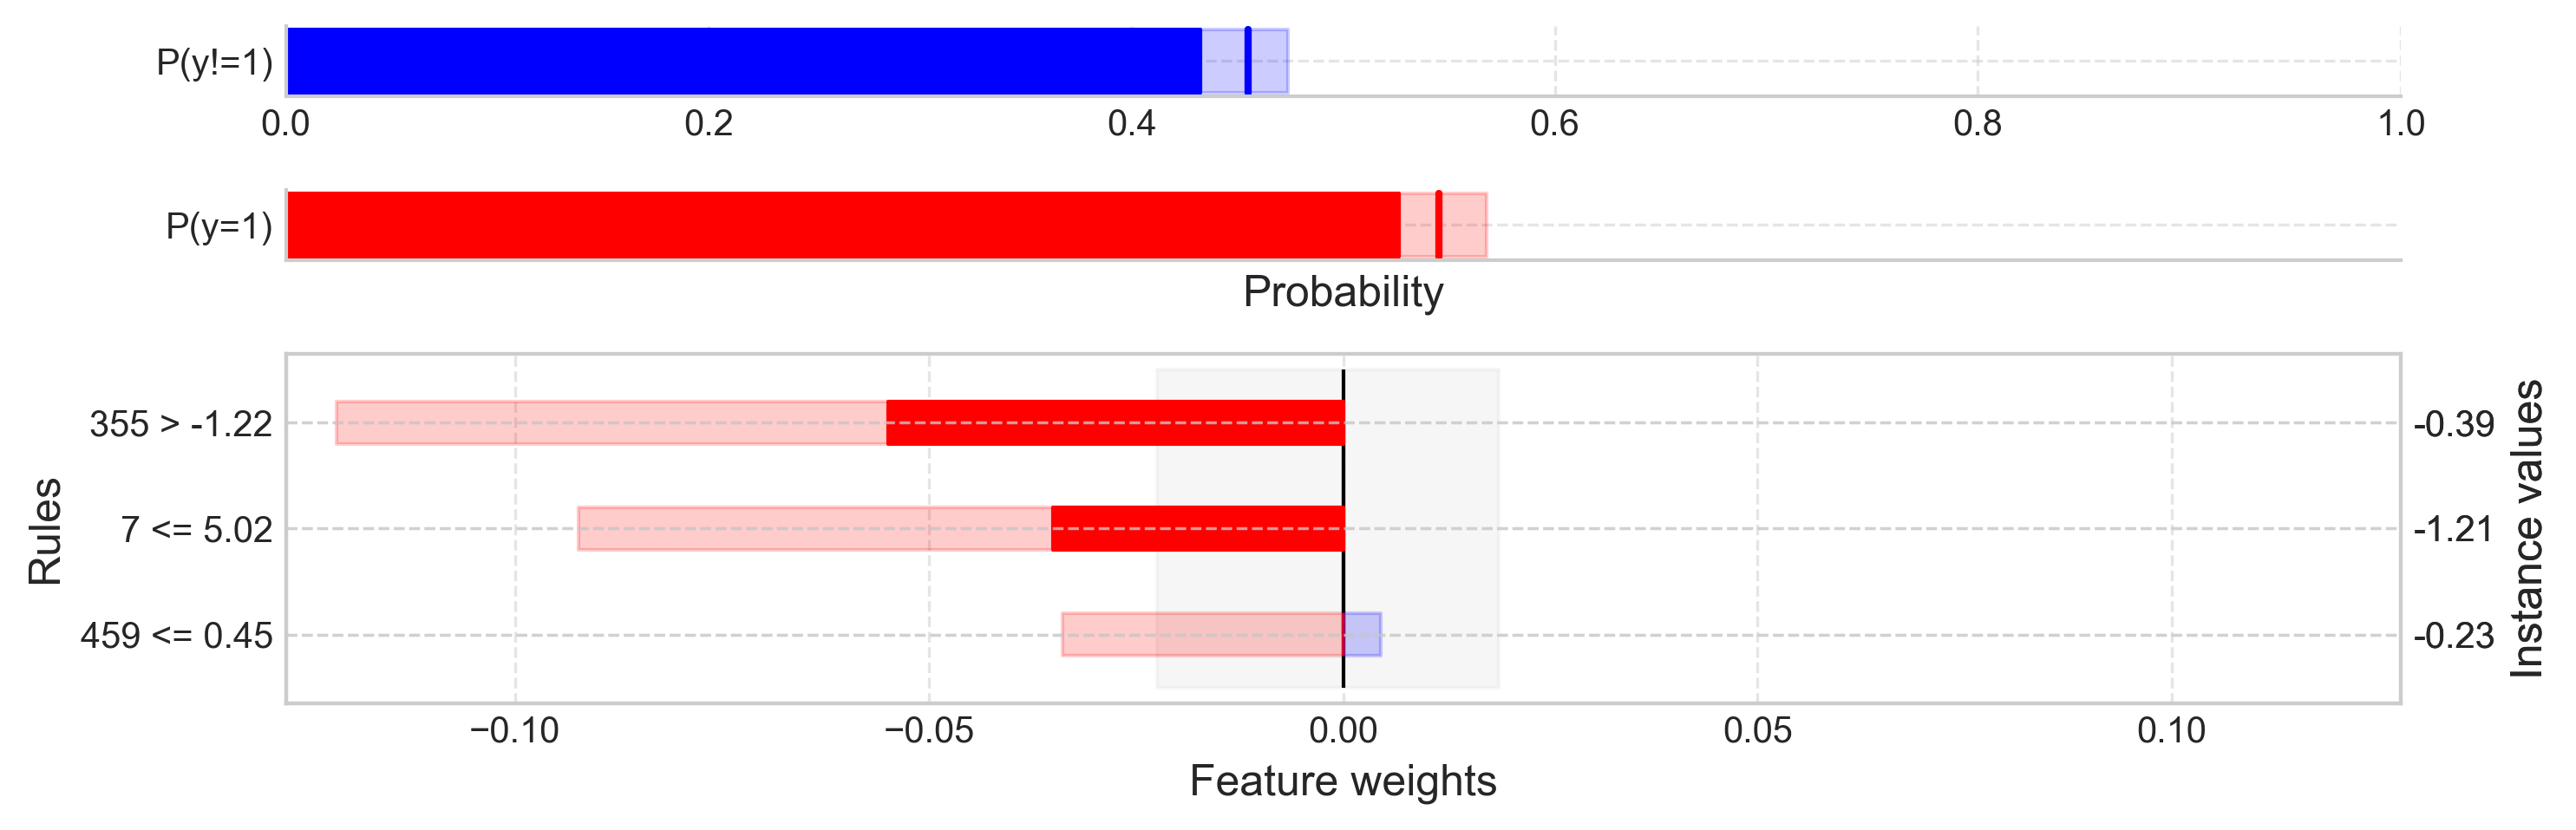

Prediction [ Low ,  High]
0.714 [0.700, 0.750]
Value : Feature                                  Weight [ Low  ,  High ]
0.09  : 1874 > -1.29                              0.714 [ 0.714,  0.714]
-0.02 : 999 > -2.37                              -0.066 [-0.086, -0.061]



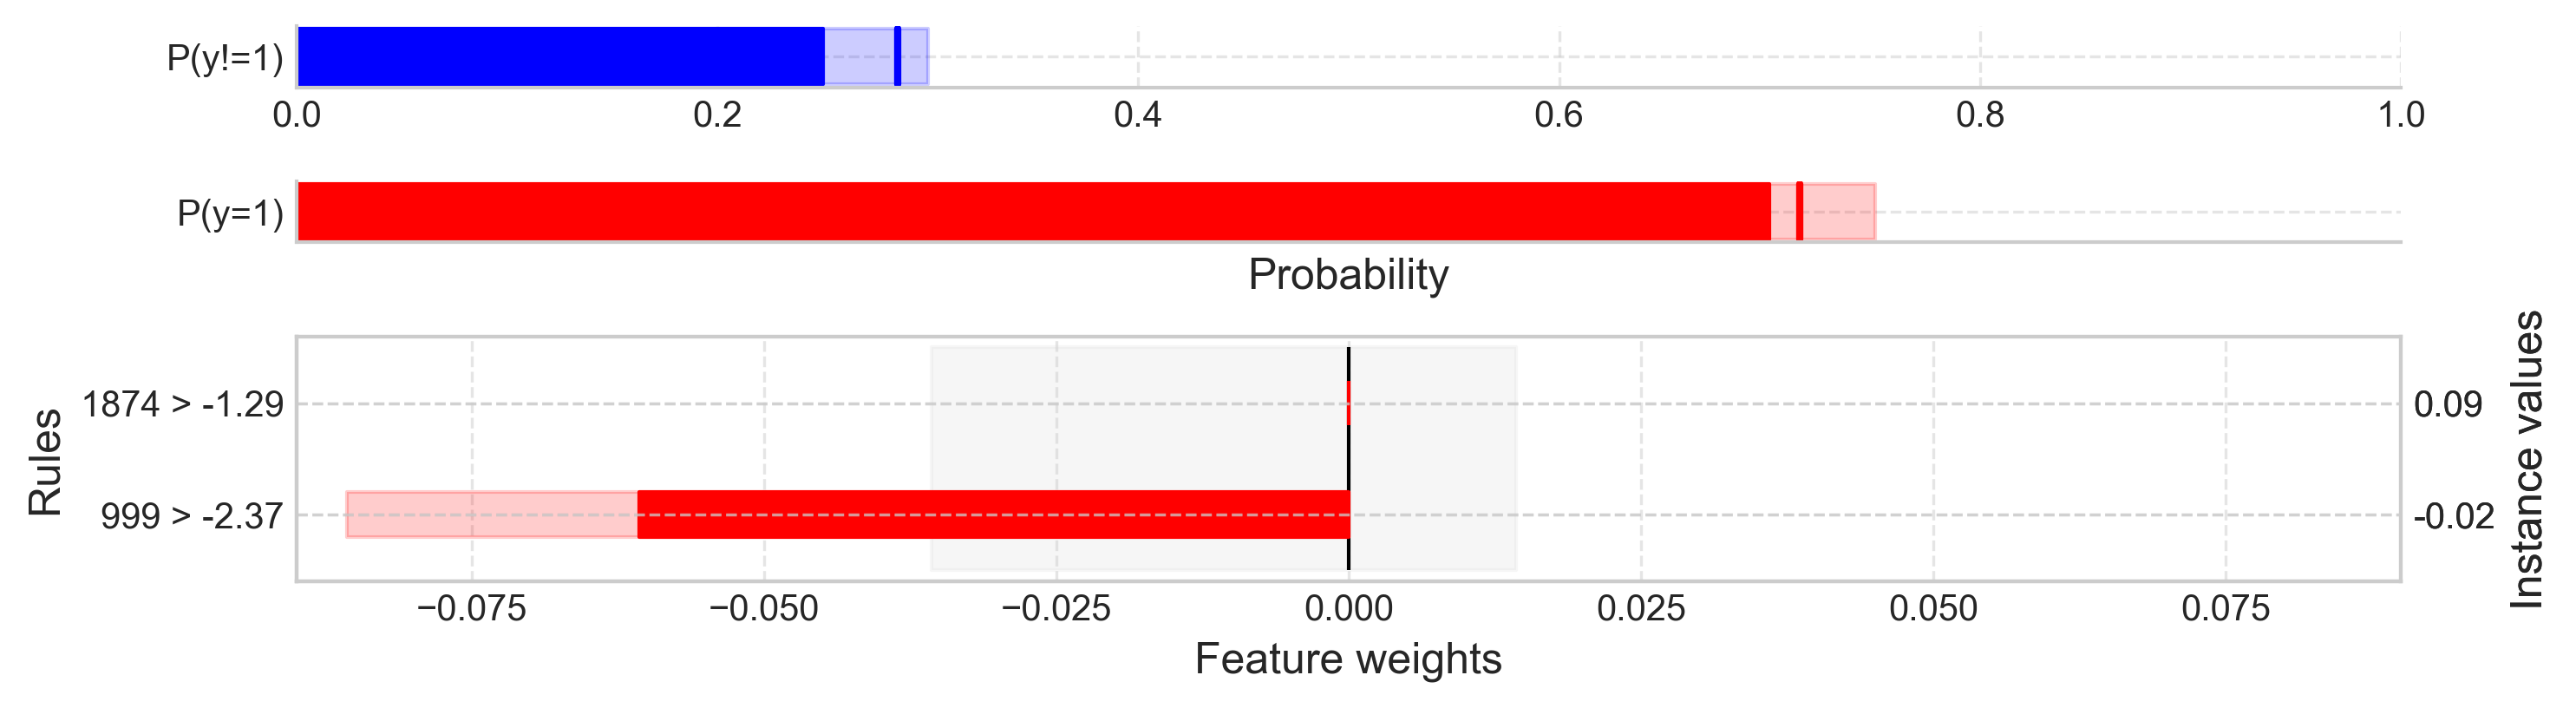

Prediction [ Low ,  High]
0.824 [0.786, 1.000]
Value : Feature                                  Weight [ Low  ,  High ]
1.93  : 1082 > -0.70                              0.824 [ 0.824,  0.824]
1.88  : 1359 > 1.14                              -0.065 [-0.176, -0.051]
0.34  : 1744 > -0.93                              0.043 [ 0.024,  0.049]
-0.91 : 1360 > -3.25                             -0.000 [-0.176,  0.038]
3.4   : 153 > -2.55                              -0.000 [-0.176,  0.038]



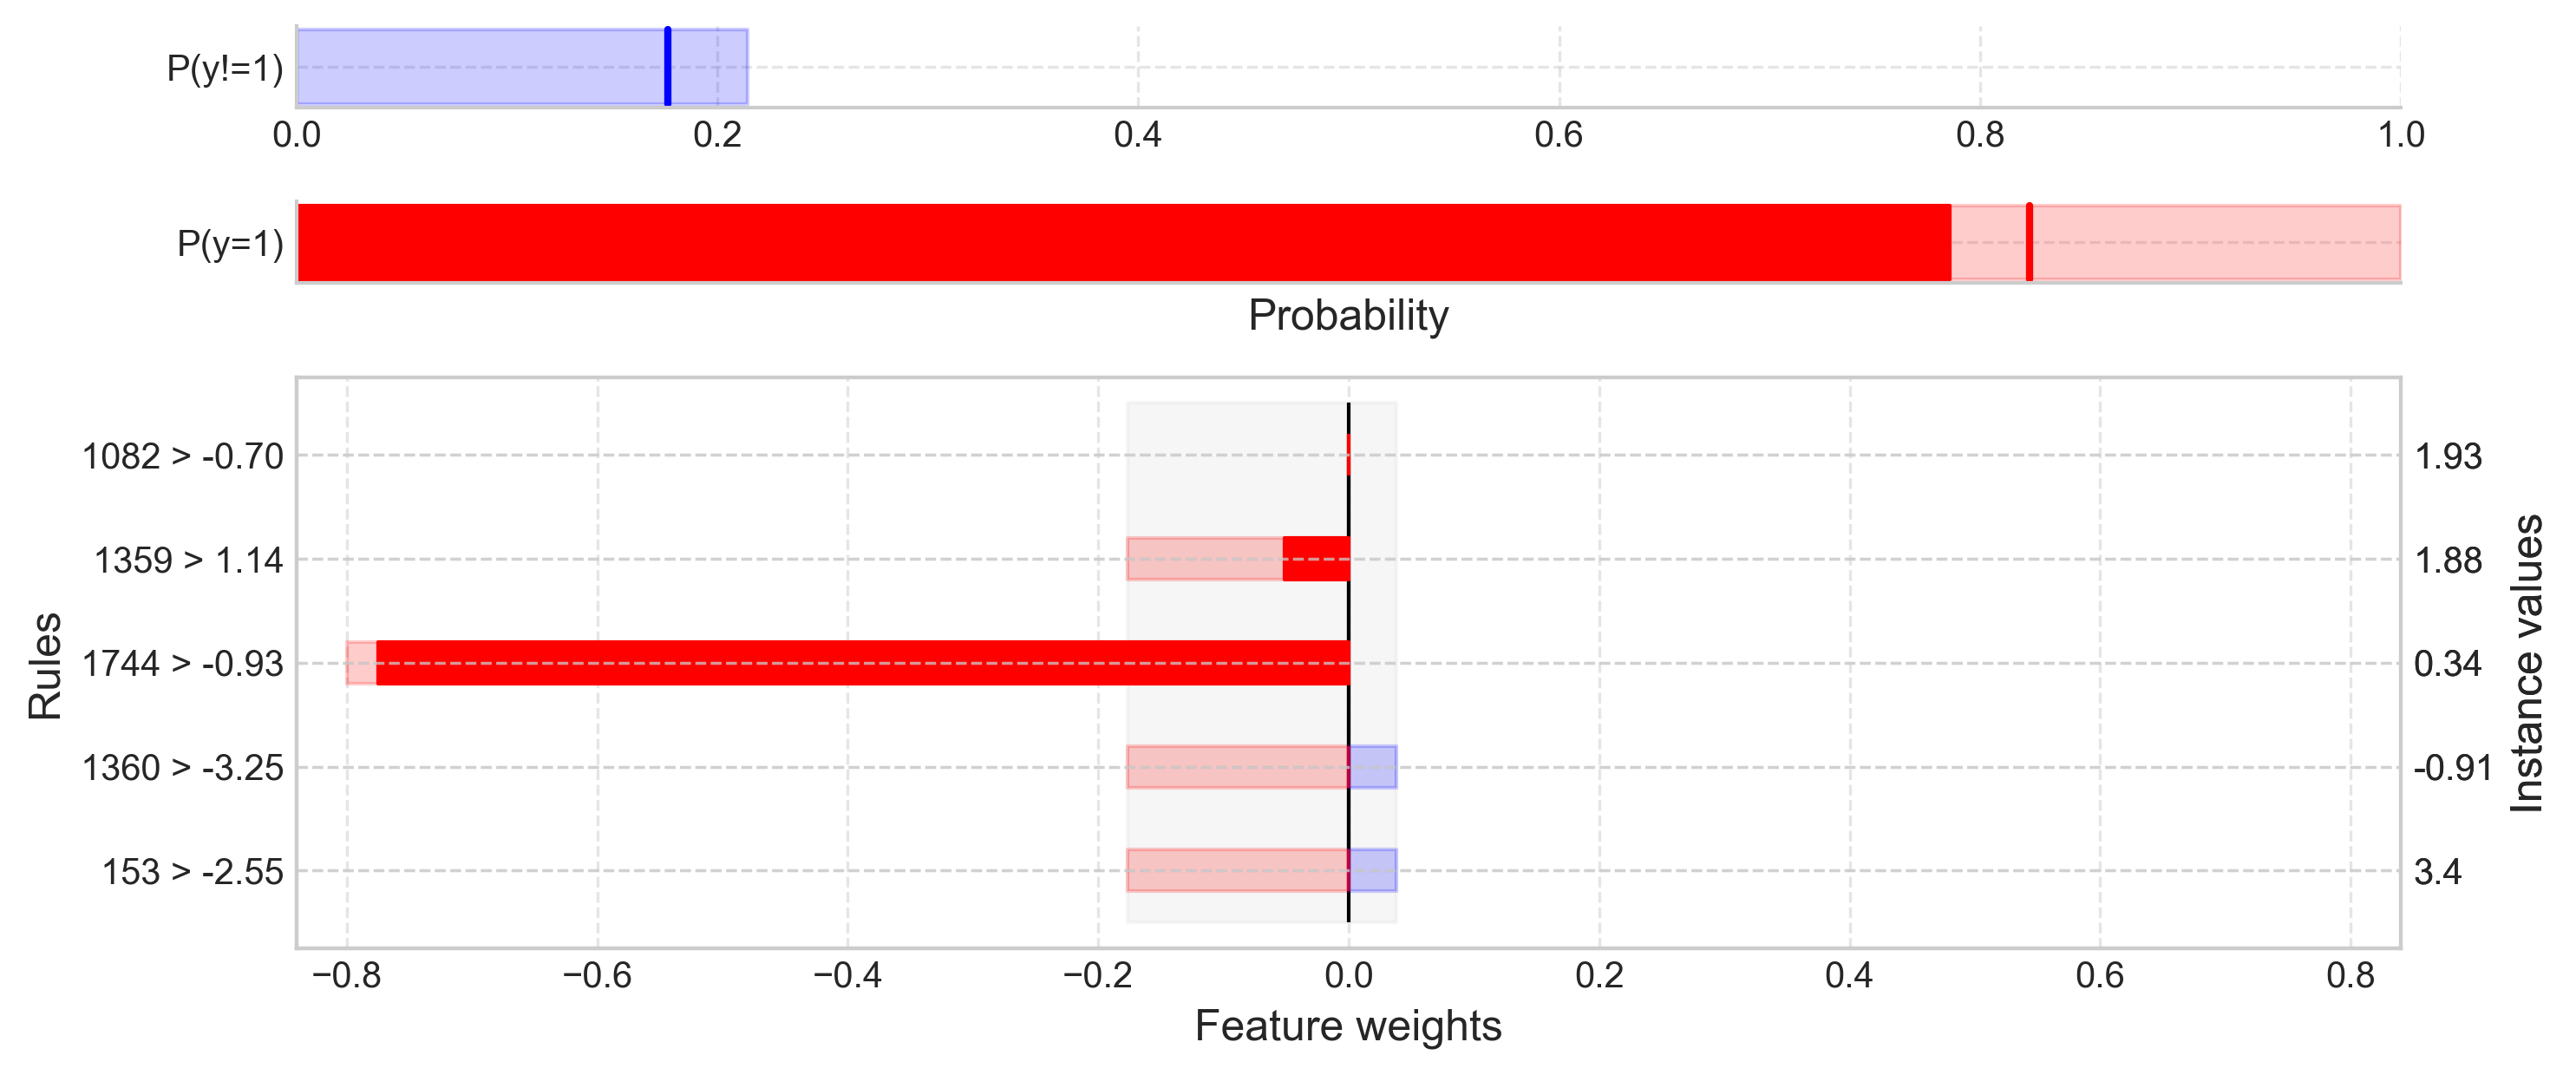

Prediction [ Low ,  High]
0.300 [0.263, 0.316]
Value : Feature                                  Weight [ Low  ,  High ]
-0.86 : 329 > -1.11                              -0.245 [-0.268, -0.226]



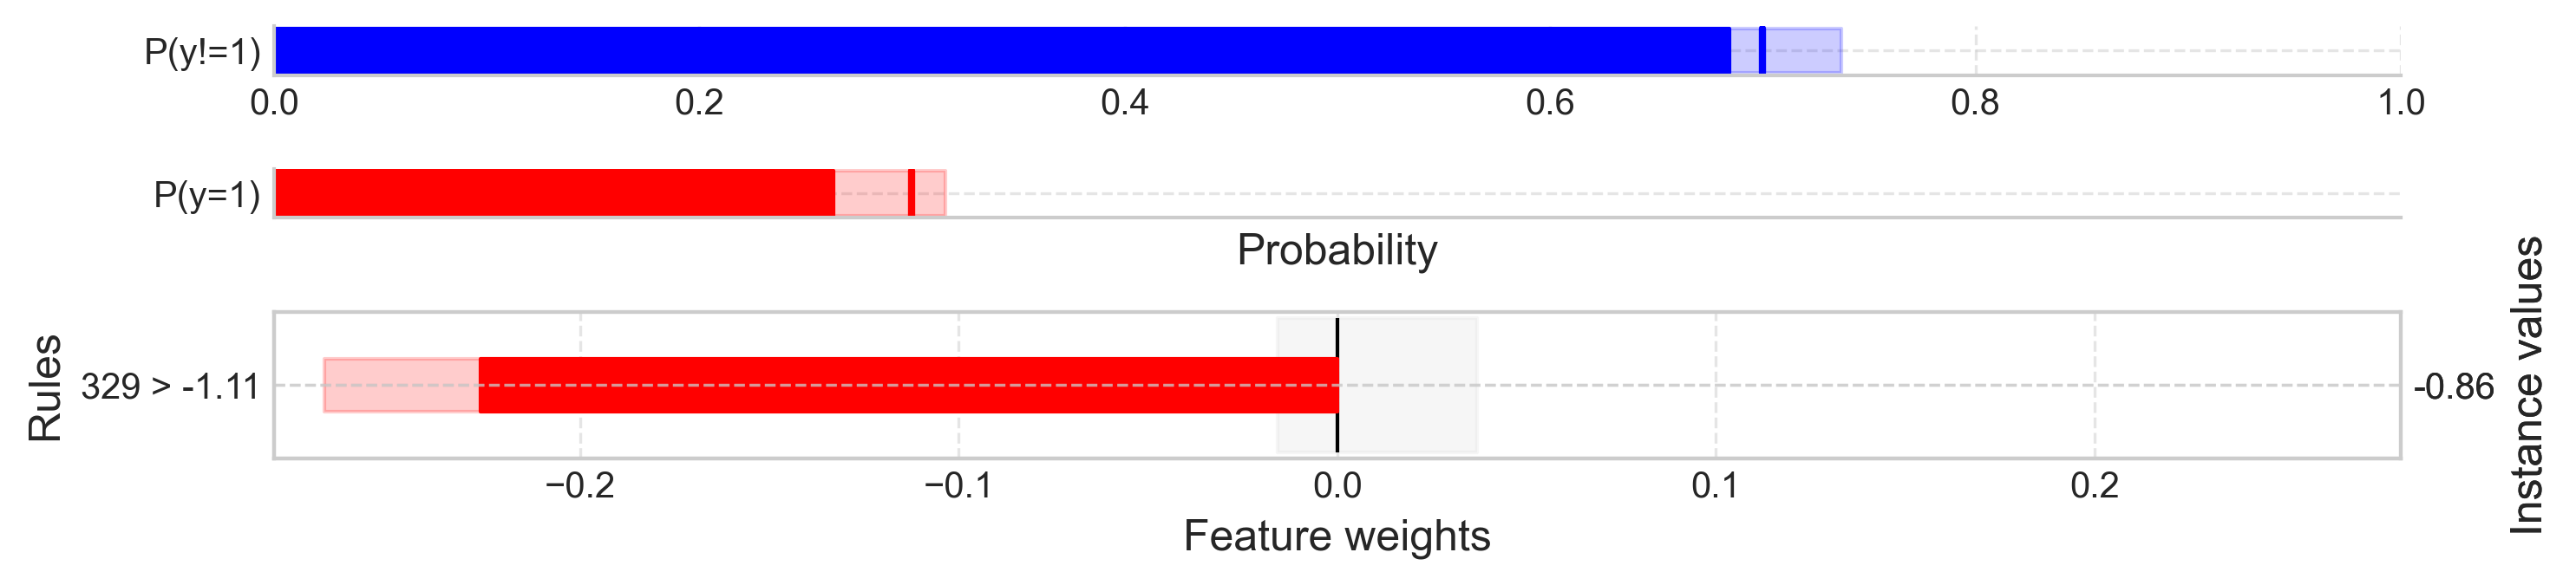

Prediction [ Low ,  High]
0.545 [0.526, 0.568]
Value : Feature                                  Weight [ Low  ,  High ]
1.21  : 329 > -1.11                              -0.080 [-0.122, -0.055]
3.02  : 7 <= 5.02                                -0.053 [-0.089, -0.030]
0.38  : 247 > -0.34                              -0.012 [-0.034,  0.005]



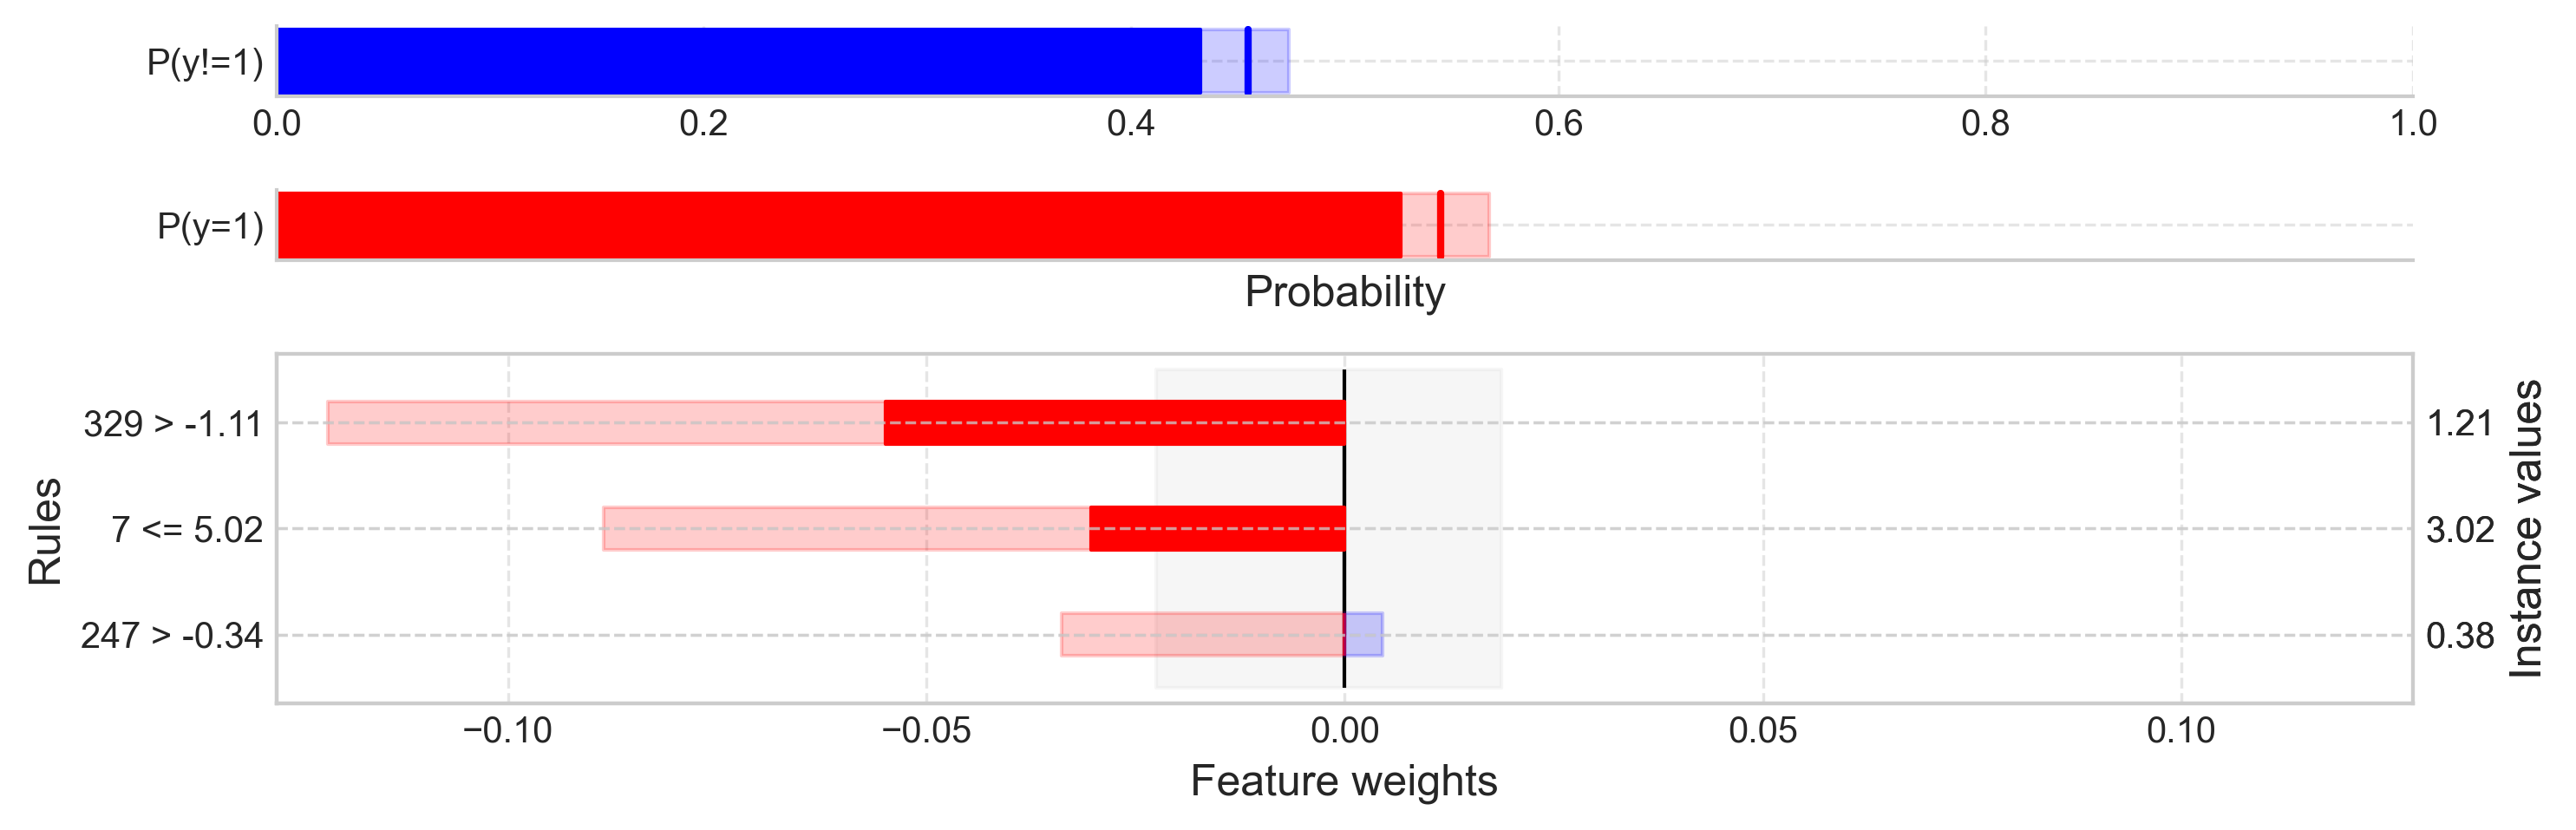

In [7]:
for e in explanations[:5]:
    print(e)
    e.plot(uncertainty=True)

In [8]:
# Inspect how many features remain after filtering
num_features = explainer.num_features
ignored = set(explanations.features_to_ignore)
kept = [f for f in range(num_features) if f not in ignored]
num_features, len(kept), kept

(2000,
 62,
 [7,
  11,
  153,
  196,
  247,
  324,
  329,
  338,
  355,
  374,
  393,
  459,
  519,
  529,
  635,
  673,
  719,
  725,
  752,
  803,
  851,
  872,
  894,
  907,
  936,
  941,
  967,
  993,
  999,
  1041,
  1082,
  1086,
  1149,
  1166,
  1177,
  1231,
  1253,
  1262,
  1267,
  1269,
  1357,
  1359,
  1360,
  1437,
  1443,
  1504,
  1558,
  1635,
  1679,
  1698,
  1702,
  1744,
  1812,
  1833,
  1834,
  1839,
  1874,
  1911,
  1937,
  1958,
  1961,
  1973])

The length of `kept` should be less than or equal to `per_instance_top_k` passed to `perf_feature_filter`.

You can tweak `per_instance_top_k` and rerun the notebook to see how the effective feature budget changes.

In [9]:
# Construct the wrapper from the config
wrapper_all = WrapCalibratedExplainer(learner)

# Calibrate the explainer (perf cache/parallel + feature filter are wired internally)
wrapper_all.calibrate(X_cal, y_cal)
explainer = wrapper_all.explainer

In [ ]:
explanations_all = wrapper_all.explain_factual(X_test)
explanations_all.features_to_ignore

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\calibrated_explanations\core\explain\orchestrator.py:403: UserWarning: Execution plugin failed for mode 'factual' (MemoryError((599600, 2000), dtype('float64'))); falling back to legacy sequential execution.
  batch = plugin.explain_batch(x, request)
